# ERSSTv5

I want to see if I can just go to the data directly to construct some predictors.

Landing page:
https://www.ncei.noaa.gov/access/metadata/landing-page/bin/iso?id=gov.noaa.ncdc:C00927

The data files can be found here:
https://www.ncei.noaa.gov/pub/data/cmb/ersst/v5/netcdf/

Installing wget on MacOS:
`brew install wget`

In [1]:
import os
import netCDF4 as nc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
# The path to the directory you want to use to store the ERSSTv5 data files
DATA_DIR = "../../ERSSTv5"

# URL to access the data
ERSST_URL = "https://www.ncei.noaa.gov/pub/data/cmb/ersst/v5/netcdf"

In [3]:
def download_data(start_year=1854, end_year=2024, data_dir=DATA_DIR, ersst_url=ERSST_URL):
    for year in range(start_year, end_year+1):
        if year % 10 == 0:
            print(year)
        for month in range(1, 12+1):
            cmd = "wget -q -nc -nd -P{:s} -nv {:s}/ersst.v5.{:4d}{:02d}.nc".format(data_dir, ersst_url, year, month)
            result = os.system(cmd)
            if result != 0:
                print("Nonzero exit status: {:s}".format(cmd))

In [4]:
# only do this if you really want to download data!
download_data()

1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
Nonzero exit status: wget -q -nc -nd -P../../ERSSTv5 -nv https://www.ncei.noaa.gov/pub/data/cmb/ersst/v5/netcdf/ersst.v5.202404.nc
Nonzero exit status: wget -q -nc -nd -P../../ERSSTv5 -nv https://www.ncei.noaa.gov/pub/data/cmb/ersst/v5/netcdf/ersst.v5.202405.nc
Nonzero exit status: wget -q -nc -nd -P../../ERSSTv5 -nv https://www.ncei.noaa.gov/pub/data/cmb/ersst/v5/netcdf/ersst.v5.202406.nc
Nonzero exit status: wget -q -nc -nd -P../../ERSSTv5 -nv https://www.ncei.noaa.gov/pub/data/cmb/ersst/v5/netcdf/ersst.v5.202407.nc
Nonzero exit status: wget -q -nc -nd -P../../ERSSTv5 -nv https://www.ncei.noaa.gov/pub/data/cmb/ersst/v5/netcdf/ersst.v5.202408.nc
Nonzero exit status: wget -q -nc -nd -P../../ERSSTv5 -nv https://www.ncei.noaa.gov/pub/data/cmb/ersst/v5/netcdf/ersst.v5.202409.nc
Nonzero exit status: wget -q -nc -nd -P../../ERSSTv5 -nv https://www.ncei.noaa.gov/pub/data/cmb/ersst/v5/netcdf/ersst.v5.202410.n

In [5]:
ds = nc.Dataset(os.path.join(DATA_DIR, "ersst.v5.200001.nc"))

In [6]:
ds['sst']

<class 'netCDF4._netCDF4.Variable'>
float32 sst(time, lev, lat, lon)
    _FillValue: -999.0
    long_name: Extended reconstructed sea surface temperature
    standard_name: sea_surface_temperature
    units: degree_C
    add_offset: 0.0
    scale_factor: 1.0
    valid_min: -3.0
    valid_max: 45.0
unlimited dimensions: 
current shape = (1, 1, 89, 180)
filling on

In [7]:
ds['sst'].shape

(1, 1, 89, 180)

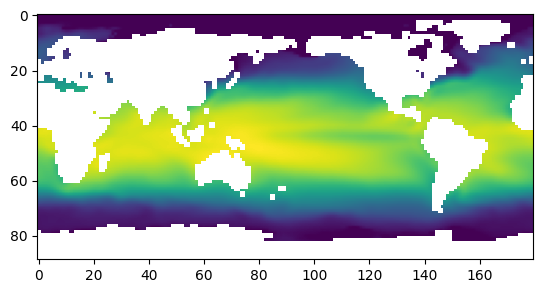

In [8]:
# need to flip latitude or the map is upside down
plt.imshow(ds['sst'][0, 0, ::-1, :])

Utility function to make a standardized timeseries plot

In [28]:
def plot_series(foo, title, limits=True):
    """
    foo: function that takes a year (eg tropic_aso)
    """
    years = range(1878, 2007+1)
    plt.figure(figsize=(8, 3))
    y = np.array([foo(y) for y in years])
    dy = y-np.mean(y)
    plt.plot(years, dy)
    if limits:
        plt.ylim(-1, 1)
    plt.fill_between(years, np.zeros_like(years), dy, where=dy>=0, color='red')
    plt.fill_between(years, np.zeros_like(years), dy, where=dy<=0, color='blue')
    plt.ylabel('Deviation from mean')
    plt.title(title)
    plt.grid();

### Nino 3.4 region

The Nino-3 region spans the eastern equatorial Pacific between 5N-5S, 150W-90W. 

The Nno 3.4 region spans the east-central equatorial Pacific between 5N-5S, 170W-120W

In [10]:
NINO_34_LAT_MASK = np.logical_and( ds['lat'][:] >= -5, ds['lat'][:] <= 5 )
NINO_34_LON_MASK = np.logical_and( ds['lon'][:] >= 360-170, ds['lon'][:] <= 360-120 )

In [11]:
def nino_34(year, month):
    ds = nc.Dataset(os.path.join(DATA_DIR, "ersst.v5.{:4d}{:02d}.nc".format(year, month)))
    return np.mean(ds['sst'][0, 0, NINO_34_LAT_MASK, NINO_34_LON_MASK])

def nino_34_djf(year):
    return np.mean([nino_34(year, 12), nino_34(year+1, 1), nino_34(year+1, 2)])

For comparison two datasets from `Exploring data sources.ipynb`

This data is from:
- https://climatedataguide.ucar.edu/climate-data/nino-sst-indices-nino-12-3-34-4-oni-and-tni
- https://psl.noaa.gov/data/correlation/nina34.data

The fact that I get a match shows that (at least for this data) I am correctly gathering raw SST data from the Nino 3.4 region.  I still have some uncertainties about how to process the index and the anomalies.

In [12]:
comp_nino_34 = pd.read_csv('nina34.data.txt',
                            delim_whitespace=True,
                            header=None,
                            skiprows=1,
                            skipfooter=5)
comp_nino_34.columns = np.arange(0,12+1) # months
comp_nino_34.set_index(0, inplace=True)
comp_nino_34.replace(-99.99, np.nan, inplace=True)

/var/folders/50/j5b90yx53cd6b3kt1ytt_dy40000gn/T/ipykernel_30248/3071333198.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  comp_nino_34 = pd.read_csv('nina34.data.txt',


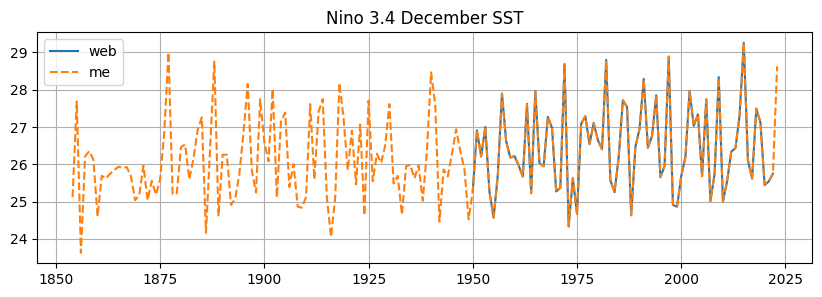

In [13]:
plt.figure(figsize=(10,3))
plt.plot(comp_nino_34.index, comp_nino_34[12])
years = range(1854, 2024)
plt.plot(years, [nino_34(y, 12) for y in years], '--')
plt.title("Nino 3.4 December SST")
plt.grid()
plt.legend(('web', 'me'))

### MDR

The Main Development Region is 6°–18°N, 20°–60°W

In [14]:
MDR_LAT_MASK = np.logical_and( ds['lat'][:] >= 6, ds['lat'][:] <= 18 )
MDR_LON_MASK = np.logical_and( ds['lon'][:] >= 360-60, ds['lon'][:] <= 360-20 )

In [15]:
def mdr(year, month):
    ds = nc.Dataset(os.path.join(DATA_DIR, "ersst.v5.{:4d}{:02d}.nc".format(year, month)))
    return np.mean(ds['sst'][0, 0, MDR_LAT_MASK, MDR_LON_MASK])

def mdr_aso(year):
    return np.mean([mdr(year, 8), mdr(year, 9), mdr(year, 10)])

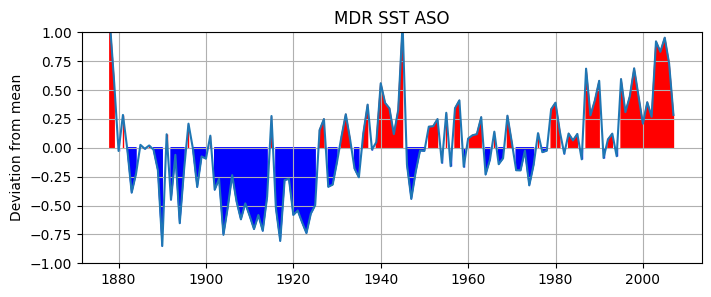

In [16]:
plot_series(mdr_aso, 'MDR SST ASO')

### ASO global tropical SST

time series of SSTs averaged across the global tropics (23.5 N to 23.5 S)

In [17]:
TROPIC_LAT_MASK = np.logical_and( ds['lat'][:] >= -23.5, ds['lat'][:] <= 23.5 )

In [18]:
def tropic(year, month):
    ds = nc.Dataset(os.path.join(DATA_DIR, "ersst.v5.{:4d}{:02d}.nc".format(year, month)))
    return np.mean(ds['sst'][0, 0, TROPIC_LAT_MASK, :])

def tropic_aso(year):
    return np.mean([tropic(year, 8), tropic(year, 9), tropic(year, 10)])

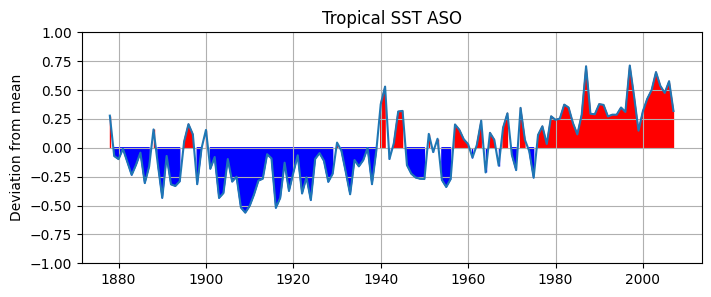

In [19]:
plot_series(tropic_aso, 'Tropical SST ASO')

Qualitatively this looks like panel (b) in Kozar 2012.  In detail there are definitely some differences.  As with some other predictors, it is hard to tell if this is due to demeaning / detrending, running mean correction, or whatever. I have taken "Anomaly" to mean deviation from the sample mean.

### Relative MDR SST ASO

In [20]:
def relative_mdr_aso(year):
    return mdr_aso(year) - tropic_aso(year)

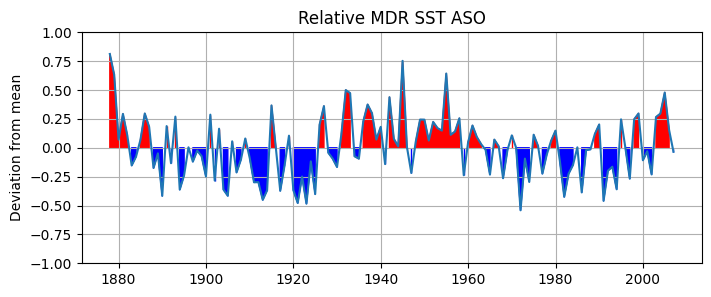

In [21]:
plot_series(relative_mdr_aso, 'Relative MDR SST ASO')

Good qualitative agreement

### Compare with other datasets

For some of these indices we have comparison points in publicly available data.  For reference see the `Exploring data sources.ipynb` notebook.

- https://climatedataguide.ucar.edu/climate-data/nino-sst-indices-nino-12-3-34-4-oni-and-tni
- which references https://psl.noaa.gov/gcos_wgsp/Timeseries/Data/nino34.long.data

The `oni_long_data` is based on `HadISST`.  The `nina34_data` is based on `ERSSTv5`

In [22]:
oni_long_data = pd.read_csv('nino34.long.data.txt',
                            delim_whitespace=True,
                            header=None,
                            skiprows=1,
                            skipfooter=5)
oni_long_data.columns = np.arange(0,12+1) # months
oni_long_data.set_index(0, inplace=True)
oni_long_data.replace(-99.99, np.nan, inplace=True)
oni_long_data

/var/folders/50/j5b90yx53cd6b3kt1ytt_dy40000gn/T/ipykernel_30248/1115719459.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  oni_long_data = pd.read_csv('nino34.long.data.txt',


,1,2,3,4,5,6,7,8,9,10,11,12
0,,,,,,,,,,,,
1870,25.58,25.57,26.43,26.96,26.59,26.61,26.19,25.99,26.22,25.82,25.86,25.79
1871,26.33,26.18,26.83,27.27,27.16,27.16,26.62,26.54,26.51,26.40,26.35,26.01
1872,25.86,26.14,26.76,27.00,27.25,27.16,26.91,26.02,25.73,25.79,25.86,25.71
1873,25.79,25.75,25.95,27.10,27.33,27.21,26.65,26.48,26.41,25.96,25.88,25.89
1874,25.64,25.70,25.85,26.83,27.00,26.96,26.22,25.82,25.62,25.49,25.33,25.45
...,...,...,...,...,...,...,...,...,...,...,...,...
2020,27.22,27.25,27.62,28.26,27.74,27.48,27.18,26.46,26.09,25.54,25.64,25.61
2021,25.54,25.82,26.54,27.22,27.45,27.63,27.03,26.50,26.25,25.95,25.78,25.52
2022,25.81,26.08,26.42,26.86,26.84,26.92,26.67,25.92,25.70,25.74,25.89,25.73


Let's make our own version of this data

In [23]:
years = list(range(1870, 2024+1))
months = list(range(1, 12+1))
nino34_data = np.zeros((len(years), 12)) * np.nan
for ii, year in enumerate(years):
    for jj, month in enumerate(months):
        try:
            nino34_data[ii, jj] = nino_34(year, month)
        except FileNotFoundError:
            pass
nino34df = pd.DataFrame(nino34_data, index=years, columns=months)

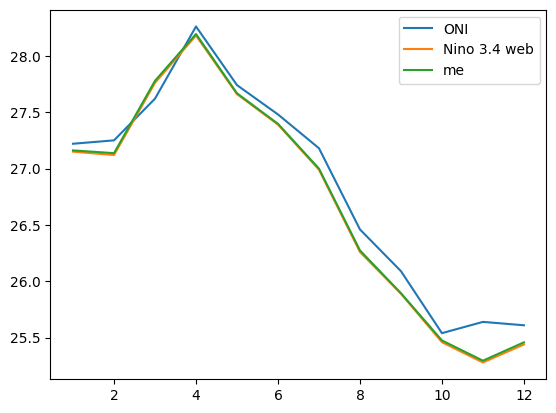

In [24]:
oni_long_data.loc[2020, :].plot()
comp_nino_34.loc[2020, :].plot()
nino34df.loc[2020, :].plot()
plt.legend(('ONI', 'Nino 3.4 web', 'me'))

It does look like I'm matching the public data r/e methodology

## Nino 1+2

0-10S, 90W-80W

In [25]:
NINO_12_LAT_MASK = np.logical_and( ds['lat'][:] >= -10, ds['lat'][:] <= 0 )
NINO_12_LON_MASK = np.logical_and( ds['lon'][:] >= 360-90, ds['lon'][:] <= 360-80 )

In [26]:
def nino_12(year, month):
    ds = nc.Dataset(os.path.join(DATA_DIR, "ersst.v5.{:4d}{:02d}.nc".format(year, month)))
    return np.mean(ds['sst'][0, 0, NINO_12_LAT_MASK, NINO_12_LON_MASK])

def nino_12_djf(year):
    return np.mean([nino_12(year, 12), nino_12(year+1, 1), nino_12(year+1, 2)])

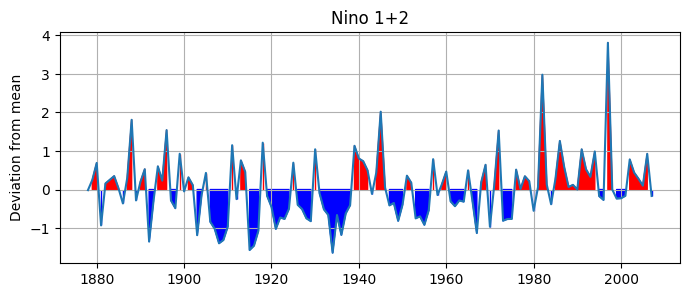

In [29]:
plot_series(nino_12_djf, 'Nino 1+2', limits=False)

## Nino 3

5N-5S, 150W-90W